In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
import torch
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from optimizers import THEOPOULA, SGLD
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, CIFAR10
import tqdm
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


# Forward Process

### Data distribution: 
$$
X_0 \sim \pi_D := N(\mu, I_d),
$$
for some unknown $\mu \in \mathbb {R}^d$. 

### Forward process:

We consider the following OU process 
$$
dX_t = -X_t \mathrm d t+ \sqrt{2} \mathrm d W_t.
$$
Its solution given $X_0$ can be represented by 
$$
X_t = m_tX_0  + \sigma_t Z,
$$
where 
\begin{align*}
    m_t &= e^{-t}, \\
    \sigma_t^2 &= 1- e^{-2t},
\end{align*}
and $Z\sim N(0, I_d)$. 



In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

   
def marginal_prob(t, x):
    t = torch.tensor(t, device=device)
    x = torch.tensor(x, device=device)

    m_t = torch.exp(-t[:, None]) 
    std = torch.sqrt(1 - torch.exp(-2 * t[:, None]))
    
    return m_t, std

def diffusion_drift(t, x):
    t = torch.tensor(t, device=device)    
    x = torch.tensor(x, device=device)
    drift = - x
        
    return drift

def diffusion_coeff(t):
    t = torch.tensor(t, device=device)    
    drift = np.sqrt(2)

    return drift
  

# score function 
$$
\nabla \log p_t(x) = -x + m_t \mu
$$
and we consider the approximated score function:
$$
s(t, \theta, x) = -x + m_t \theta.
$$

Furthermore, given the initial sample $x_0$, the corresponding conditional score functions are 
$$
\nabla \log p_t(x|x_0) = -\frac{x - m_t x_0}{\sigma_t^2}
$$


# Loss function

our objective function is 
\begin{align}
U(\theta)&:= \mathbb{E}\left[\kappa(\tau) [\| \nabla \log_\tau (X_\tau)- s(\tau, \theta, X_\tau)\|^2] \right]\\
&=\mathbb{E}\left[\kappa(t) \left \|
  \sigma_\tau^{-1} Z + s(\tau, \theta, m_\tau X_0 + \sigma_\tau Z) \right\|^2 \right].
\end{align}
where $\tau \sim Uni([\epsilon, T])$. In this experiment, we set $\epsilon = 10^{-5}$, $T=1$, and $\kappa(t)=\sigma_t^2$. 


In [9]:
def loss_fn(model, x, marginal_prob, eps=1e-5, T=1):
    random_t = torch.rand(x.shape[0], device=x.device) * (T - eps) + eps  
    z = torch.randn_like(x)
    mean, std = marginal_prob(random_t, x)    

    pt_x = mean * x + z * std
    score = model(random_t, pt_x)
    
    loss = torch.mean(torch.sum((z + std * score)**2, dim=1))    
    return loss

In [10]:
class Approx_score(nn.Module):
    def __init__(self, input_dim, marginal_prob):
        super(Approx_score, self).__init__()
        self.intput_dim = input_dim
        self.marginal_prob = marginal_prob        
        self.params = nn.Parameter(torch.zeros(input_dim))
        
    def forward(self, t, x):
        mean, std = self.marginal_prob(t, x)
        approx_score = -x + mean * self.params #-(x -  torch.exp(-t[:, None]) * self.params) / std**2
        
        return approx_score 

# Data generation

For visualization, we first consider the case with $d=2$ and each component of $\mu$ is generated from $Uni(-2,2)$. 

In [11]:
input_dim = 2
mu_D = [-1.23486883, -0.89244735]#np.random.rand(2) * 5 - 2.5

print('Unknown mean of the initial data is {}'.format(mu_D))


Unknown mean of the initial data is [-1.23486883, -0.89244735]


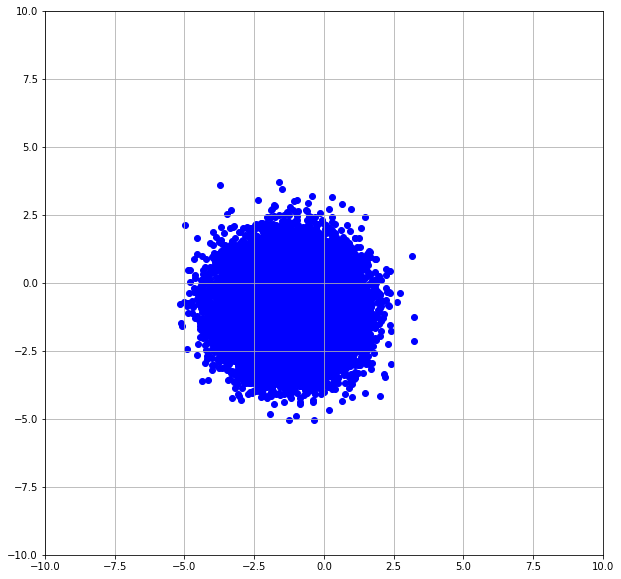

In [12]:
M = 50000
X = mu_D + np.random.randn(M, input_dim)
plt.figure(figsize=(10, 10))
plt.scatter(X[:,0], X[:, 1], c='blue', marker='o')
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.grid(True)
#plt.title('initial data')
plt.show()

# Forward process

In [13]:
batch_size = 128
n_epochs = 200
lr=1e-4
beta = 1e14
T = 2
eps = 0
optimizer_name = 'SGLD'


X_tensor = torch.from_numpy(X).float().to(device)
dataset = TensorDataset(X_tensor)
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)


C:\Users\ldy18\anaconda3\envs\py36_cuda\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  import sys
C:\Users\ldy18\anaconda3\envs\py36_cuda\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
C:\Users\ldy18\anaconda3\envs\py36_cuda\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


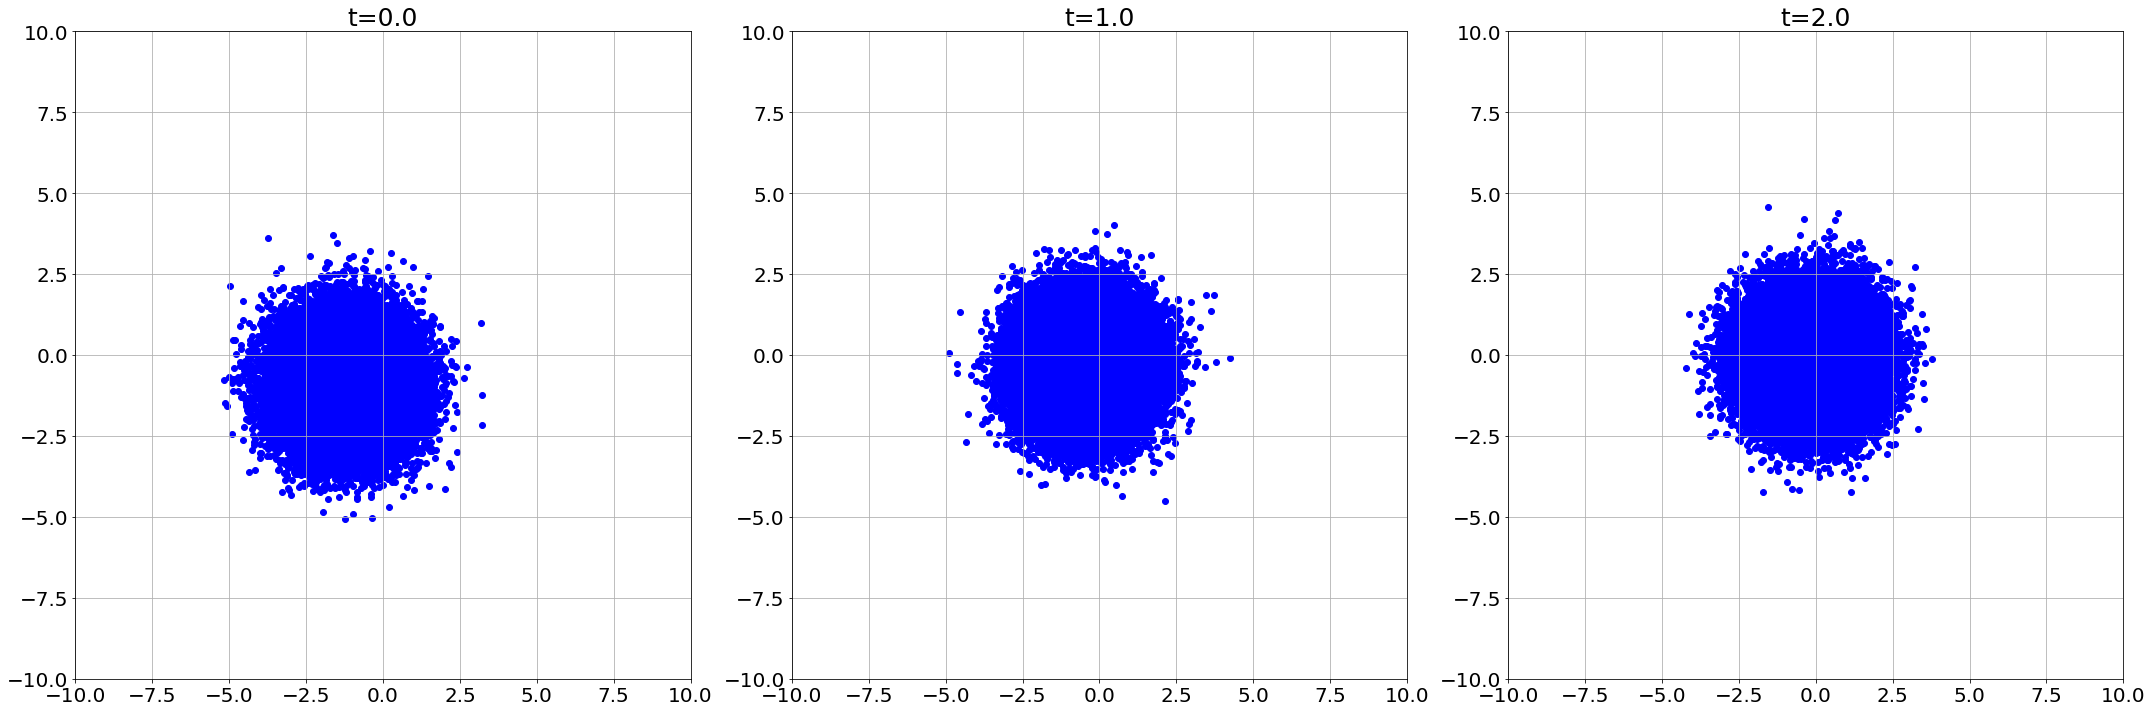

In [14]:
num_steps = 3
n_rows = 1
time_steps = torch.linspace(0, T, num_steps, device=device)

plt.figure(figsize=(30,10))
for i, t in enumerate(time_steps, 1):
    plt.subplot(n_rows, num_steps/n_rows, i)
    mean_accumulator = []
    for i, data in enumerate(data_loader):
        data = data[0]      
        #print(data.shape, t)
        random_t =  torch.ones(data.shape[0], device=device) * t
        mean, std = marginal_prob(random_t, data)
        Z = torch.randn_like(data)

        Xt = mean * data + std * Z
        Xt = Xt.cpu().numpy()
        
        
        plt.scatter(Xt[:,0], Xt[:, 1], c='blue', marker='o')
        
        
        mean_accumulator.append(Xt)

#     mean_accumulator = np.concatenate(mean_accumulator, axis=0)
#     mean_x = np.mean(mean_accumulator[:,0])
#     mean_y = np.mean(mean_accumulator[:,1])
    
#     print(mean_x, mean_y)
    
    plt.title("t={}".format(t), fontdict={'fontsize':25})
#     plt.plot(np.mean(Xt[:,0]), np.mean(Xt[:,1]), 'ro', markersize=10)
    plt.xlim([-10,10])
    plt.ylim([-10,10])
    plt.grid(True)
        
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
plt.tight_layout()
plt.show()
        
    
        


In [15]:
score_model = Approx_score(input_dim, marginal_prob).to(device)

if optimizer_name == 'SGLD':
    optimizer = SGLD(score_model.parameters(), lr=lr, beta=beta)
elif optimizer_name == 'ADAM':
    optimizer = Adam(score_model.parameters(), lr=lr)
history = {'loss': [],
           'params': []          
          }

model_name = 'optimizer{}-epochs{}-bs{}-lr{}-eps{}-beta{:.1e}.pt'.format(optimizer_name, n_epochs, batch_size, lr, eps, beta)


In [16]:
num_steps =  1000
eps = 0
sample_batch_size = 100000

def Euler_Maruyama_sampler(score_model, 
                           marginal_prob,
                           diffusion_drift,
                           diffusion_coeff, 
                           batch_size,
                           num_steps=num_steps, 
                           device='cuda', 
                           eps=eps,
                           T=T):
    
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, input_dim, device=device)    
    time_steps = torch.linspace(T, eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    
 
    with torch.no_grad():
        for time_step in time_steps:            
            #print(time_step)
            batch_time_step = torch.ones(x.shape[0], device=device) * time_step
      
            mean_x = x + (x + 2 * score_model(batch_time_step, x)) * step_size
            
            
            x = mean_x + torch.sqrt(2 * step_size) * torch.randn_like(x)               
  
    return mean_x

In [17]:
def compute_ass4(score_model, 
                 marginal_prob,
                 diffusion_drift,
                 diffusion_coeff, 
                 batch_size,
                 num_steps=num_steps, 
                 device='cuda', 
                 eps=eps,
                 T=T):
    
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, input_dim, device=device)    
    time_steps = torch.linspace(T, eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    
    error4 = 0
    with torch.no_grad():
        for time_step in time_steps:            
            #print(time_step)
            batch_time_step = torch.ones(x.shape[0], device=device) * time_step
      
            mean_x = x + (x + 2 * score_model(batch_time_step, x)) * step_size
            
            
            x = mean_x + torch.sqrt(2 * step_size) * torch.randn_like(x)     
            mu_D_tensor = torch.tensor(mu_D, device='cuda')                
            
            error4_t = (- x + torch.exp(-(T-batch_time_step).unsqueeze(-1)) * mu_D_tensor - score_model((T-batch_time_step), x))**2            
            error4 = error4 + error4_t
            
 
    return error4.mean(1).mean() * step_size

In [18]:
#train하면 comment 해제
score_model = Approx_score(input_dim, marginal_prob).to(device)
hist = {'epoch':[], 'loss':[], 'fid':[], 'error4':[]}
if optimizer_name == 'SGLD':
    optimizer = SGLD(score_model.parameters(), lr=lr, beta=beta)
elif optimizer_name == 'ADAM':
    optimizer = Adam(score_model.parameters(), lr=lr)
history = {'loss': [],
           'params': []        
          }

best_loss = 999
for epoch in range(n_epochs):
    total_loss = 0
    num_items = 0
    
    for i, data in enumerate(data_loader):        
        data = data[0]        
        loss = loss_fn(score_model, data, marginal_prob, eps=eps, T=T)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.shape[0]
        num_items += data.shape[0]
    
    print('epoch{}- loss: {:5f}, estimated params:{}'.format(epoch, total_loss/num_items, score_model.params.data))
    history['params'].append(score_model.params.data)
    history['loss'].append(total_loss/num_items)
    
    params = score_model.params.data.cpu().numpy()
    error = np.sum((mu_D - params)**2)
    loss = total_loss/num_items
    
    if best_loss > loss:
        best_loss = loss
        best_params = params
        best_model = score_model.state_dict()        
        model_name = './save/optimizer{}-epochs{}-bs{}-lr{}-eps{}-beta{:.1e}-epoch{}.pt'.format(optimizer_name, n_epochs, batch_size, lr, eps, beta, epoch)
        
        
        samples = Euler_Maruyama_sampler(score_model, 
                  marginal_prob,
                  diffusion_drift,
                  diffusion_coeff, 
                  sample_batch_size,                   
                  device=device,
                  eps = eps,
                  T=T)
        samples = samples.cpu().numpy()#.clamp(0.0, 1.0)  
        
        error4 = compute_ass4(score_model, 
                  marginal_prob,
                  diffusion_drift,
                  diffusion_coeff, 
                  sample_batch_size,                   
                  device=device,
                  eps = eps,
                  T=T)
        error4 = error4.cpu().numpy()
        #fid = np.sqrt((mu_D[0] - samples[:, 0].mean())**2 + (mu_D[1] - samples[:, 1].mean())**2 )
        torch.save(best_model, model_name)
        hist['epoch'].append(epoch)
        hist['loss'].append(loss)
        hist['error4'].append(error4)
        hist['fid'].append(error)
        print(epoch, best_loss, error4, error, best_params)



C:\Users\ldy18\anaconda3\envs\py36_cuda\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
C:\Users\ldy18\anaconda3\envs\py36_cuda\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


epoch0- loss: 0.767168, estimated params:tensor([-0.0116, -0.0082], device='cuda:0')
0 0.7671680681419373 0.5602925 2.278252499271045 [-0.01157886 -0.00824481]
epoch1- loss: 0.755177, estimated params:tensor([-0.0230, -0.0165], device='cuda:0')
1 0.7551770009040832 0.5498899 2.235952176480433 [-0.02295318 -0.01654061]
epoch2- loss: 0.753011, estimated params:tensor([-0.0344, -0.0247], device='cuda:0')
2 0.7530106592369079 0.5396409 2.194281009706154 [-0.03435521 -0.02466393]
epoch3- loss: 0.756468, estimated params:tensor([-0.0456, -0.0329], device='cuda:0')
epoch4- loss: 0.745406, estimated params:tensor([-0.0567, -0.0409], device='cuda:0')
4 0.7454061394691467 0.51969767 2.1131863366363035 [-0.05671594 -0.04089459]
epoch5- loss: 0.742481, estimated params:tensor([-0.0677, -0.0489], device='cuda:0')
5 0.7424811485099793 0.51000434 2.0737685180068253 [-0.06772587 -0.04891559]
epoch6- loss: 0.741895, estimated params:tensor([-0.0786, -0.0568], device='cuda:0')
6 0.7418948661231994 0.500

epoch63- loss: 0.574964, estimated params:tensor([-0.5591, -0.4030], device='cuda:0')
63 0.5749635845947265 0.17121115 0.696175663824066 [-0.55914086 -0.40299115]
epoch64- loss: 0.567323, estimated params:tensor([-0.5654, -0.4076], device='cuda:0')
64 0.5673227876472473 0.16804057 0.6832836495591645 [-0.5653877 -0.4075982]
epoch65- loss: 0.574294, estimated params:tensor([-0.5717, -0.4121], device='cuda:0')
epoch66- loss: 0.569424, estimated params:tensor([-0.5778, -0.4166], device='cuda:0')
epoch67- loss: 0.571160, estimated params:tensor([-0.5840, -0.4209], device='cuda:0')
epoch68- loss: 0.572713, estimated params:tensor([-0.5901, -0.4253], device='cuda:0')
epoch69- loss: 0.569991, estimated params:tensor([-0.5961, -0.4296], device='cuda:0')
epoch70- loss: 0.569774, estimated params:tensor([-0.6022, -0.4340], device='cuda:0')
epoch71- loss: 0.566712, estimated params:tensor([-0.6081, -0.4383], device='cuda:0')
71 0.5667115107917786 0.1473307 0.5990730735423113 [-0.60814387 -0.438256

epoch132- loss: 0.509390, estimated params:tensor([-0.8825, -0.6356], device='cuda:0')
132 0.5093896327209473 0.046763074 0.1901472145719765 [-0.8824655 -0.6356223]
epoch133- loss: 0.512573, estimated params:tensor([-0.8858, -0.6380], device='cuda:0')
epoch134- loss: 0.508990, estimated params:tensor([-0.8889, -0.6403], device='cuda:0')
134 0.5089903426551818 0.045066282 0.18324775405558558 [-0.88892615 -0.6403136 ]
epoch135- loss: 0.511884, estimated params:tensor([-0.8922, -0.6427], device='cuda:0')
epoch136- loss: 0.510510, estimated params:tensor([-0.8954, -0.6451], device='cuda:0')
epoch137- loss: 0.512349, estimated params:tensor([-0.8986, -0.6473], device='cuda:0')
epoch138- loss: 0.512210, estimated params:tensor([-0.9018, -0.6496], device='cuda:0')
epoch139- loss: 0.512776, estimated params:tensor([-0.9049, -0.6519], device='cuda:0')
epoch140- loss: 0.509707, estimated params:tensor([-0.9078, -0.6542], device='cuda:0')
epoch141- loss: 0.510114, estimated params:tensor([-0.9109

No handles with labels found to put in legend.


Text(0, 0.5, '$W_2(\\mathcal{L}(Y_K^{\\mathrm{EM}}), \\pi_D)$')

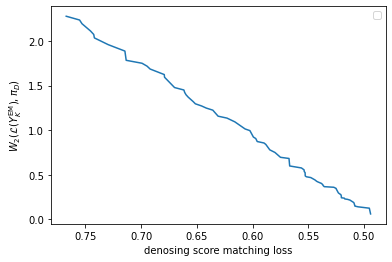

In [23]:
plt.plot(hist['loss'], hist['fid'])
plt.gca().invert_xaxis()

#x_values = np.linspace(min(hist['loss']), max(hist['loss']), 100)
#sqrt_values =  5*(x_values)
#plt.plot(x_values, sqrt_values, label='reference line (slope=1)', linestyle='--')

#plt.plot(x_values, x_values, label='y = x', linestyle='--')

plt.legend()
plt.xlabel('denosing score matching loss')
plt.ylabel(r'$W_2(\mathcal{L}(Y_K^{\mathrm{EM}}), \pi_D)$')


No handles with labels found to put in legend.


Text(0, 0.5, '$W_2(\\mathcal{L}(Y_K^{\\mathrm{EM}}), \\pi_D)$')

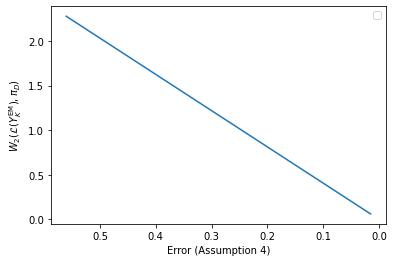

In [22]:
plt.plot(hist['error4'], hist['fid'])
plt.gca().invert_xaxis()

#x_values = np.linspace(min(hist['error4']), max(hist['error4']), 100)
#sqrt_values = 4 * x_values + 0.2
#plt.plot(x_values, sqrt_values, label='reference line (slope=1)', linestyle='--')

#plt.plot(x_values, x_values, label='y = x', linestyle='--')

plt.legend()
plt.xlabel('Error (Assumption 4)')
plt.ylabel(r'$W_2(\mathcal{L}(Y_K^{\mathrm{EM}}), \pi_D)$')


In [21]:
print('Unknown mean of the initial data is {}'.format(mu_D))
print('estimated parameter \theta:{}'.format(best_params))

Unknown mean of the initial data is [-1.23486883, -0.89244735]
estimated parameter 	heta:[-0.732402   -0.52756035]


# Sampling reverse SDE

The reverse SDE 
$$
\mathrm{d} Y_t =  (Y_t+ 2 \nabla \log p_{T-t}(Y_t) )\mathrm{d}t  + \sqrt{2}\mathrm{d}B_t
$$
since we approximate the score function as $s(t, \theta^*, x)$, we sample the following SDE:
$$
\mathrm{d} Y_t =  (Y_t+ 2 s(T-t,\theta^*,Y_t) )\mathrm{d}t  + \sqrt{2}\mathrm{d}B_t.
$$


Euler-Maruyama approximation:
$$
Y_{k+1}^{EM} = Y_{k}^{EM} + \gamma (Y_{k}^{EM}+ 2 s(T-t,\theta^*,Y_{k}^{EM}) ) + \sqrt{2\gamma}Z_{k+1}.
$$

# Generated samples

In [14]:
T

2

C:\Users\user\anaconda3\envs\py36_cuda\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
C:\Users\user\anaconda3\envs\py36_cuda\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


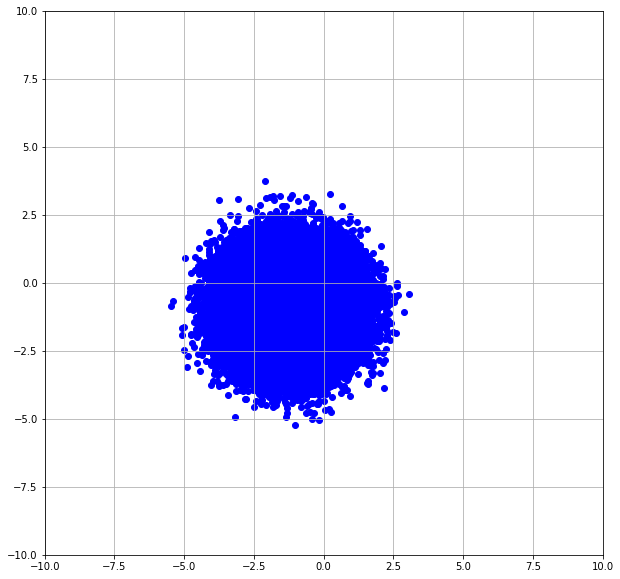

In [15]:
ckpt = torch.load(model_name, map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 100000

samples = Euler_Maruyama_sampler(score_model, 
                  marginal_prob,
                  diffusion_drift,
                  diffusion_coeff, 
                  sample_batch_size,                   
                  device=device,
                  eps = eps,
                  T=T)
samples = samples.cpu().numpy()#.clamp(0.0, 1.0)


plt.figure(figsize=(10, 10))
plt.scatter(samples[:,0], samples[:, 1], c='blue', marker='o')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.grid(True)
#plt.title('generated data')
plt.show()

In [16]:
print(samples[:, 0].mean(), samples[:, 1].mean())

-1.2106698 -0.88649654


In [20]:
np.sqrt((mu_D[0] - samples[:, 0].mean())**2 + (mu_D[1] - samples[:, 1].mean())**2 )

0.024920017636388177

C:\Users\user\anaconda3\envs\py36_cuda\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  import sys
C:\Users\user\anaconda3\envs\py36_cuda\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
C:\Users\user\anaconda3\envs\py36_cuda\lib\site-packages\ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


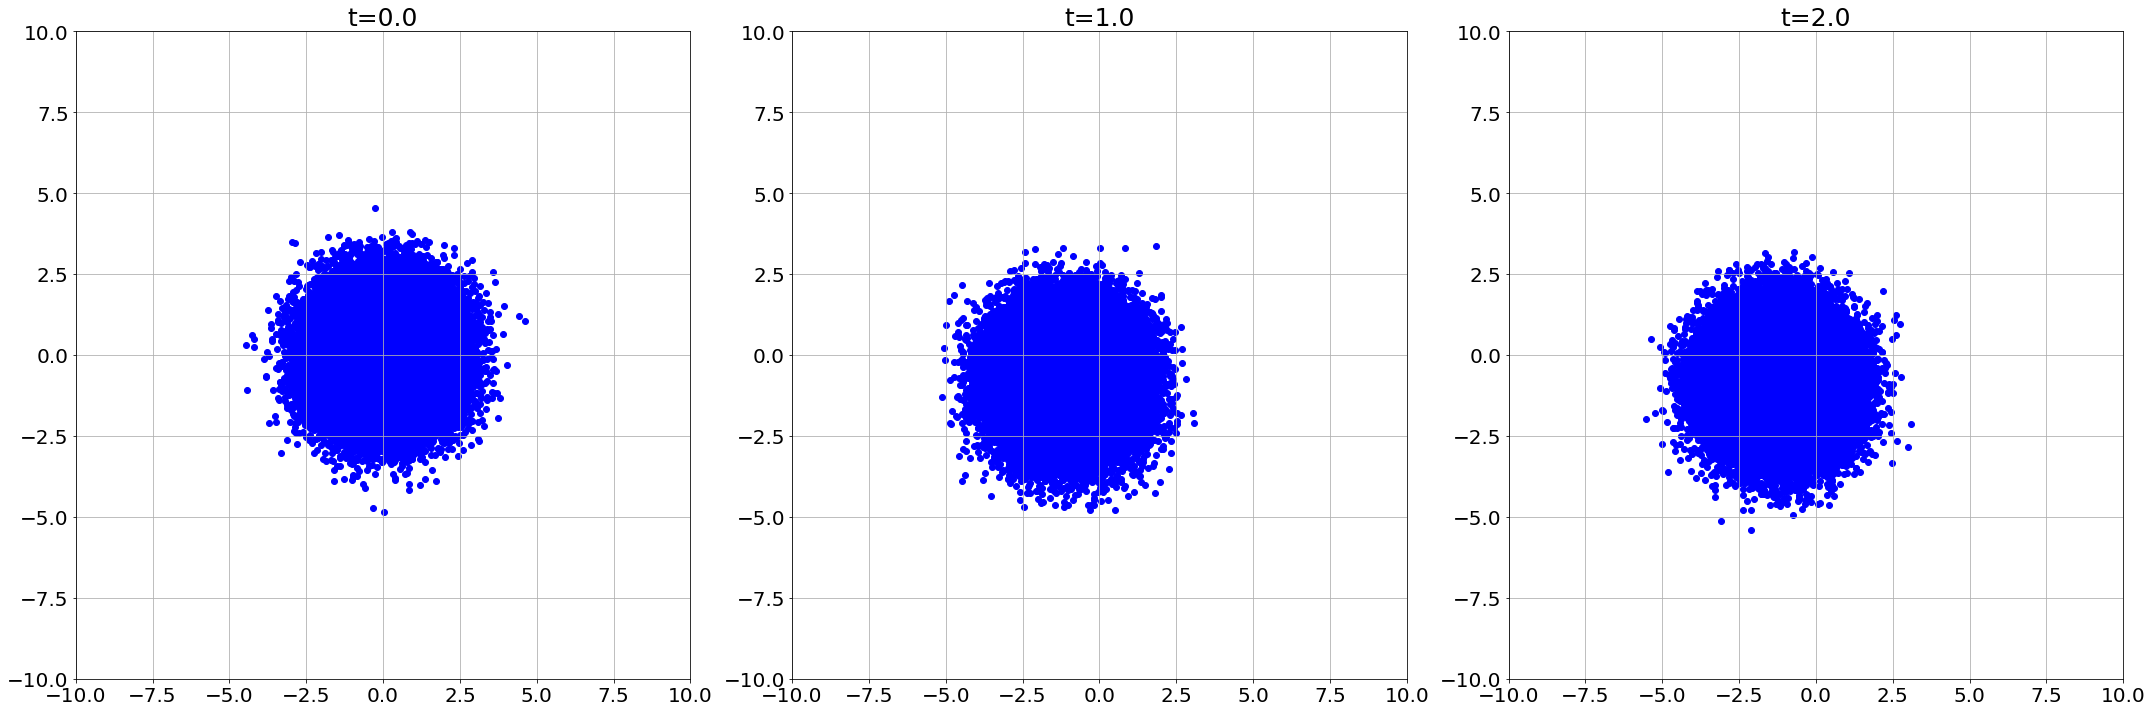

In [33]:
num_steps = 3
n_rows = 1
plt.figure(figsize=(30,10))
time_steps = torch.linspace(0, T, num_steps, device=device)

for i, t in enumerate(time_steps, 1):
    plt.subplot(n_rows, num_steps/n_rows, i)
    
    samples = Euler_Maruyama_sampler(score_model, 
                  marginal_prob,
                  diffusion_drift,
                  diffusion_coeff, 
                  sample_batch_size,                   
                  device=device,
                  eps = eps,
                  T=t if t>0 else eps )
    samples = samples.cpu().numpy()
    plt.scatter(samples[:,0], samples[:, 1], c='blue', marker='o')
    
    plt.title("t={}".format(t), fontdict={'fontsize':25})
    plt.xlim([-10,10])
    plt.ylim([-10,10])
    plt.grid(True)
        
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
plt.tight_layout()
plt.show()
        
    

# Multivariate normality test
- Mardia's multivariate normality test


I got p-value = 0.564535, thus we cannot reject the null hypothesis. That is, the generated data is reasonably consistent with the hypothesis of a multivariate normal distribution.